In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import interpolation as itp

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, d=64):
        super(Generator, self).__init__()
        #1x1
        self.deconv1 = nn.ConvTranspose2d(z_dim, d*16, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*16)
        #4x4
        self.deconv2 = nn.ConvTranspose2d(d*16, d*8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*8)
        #8x8
        self.deconv3 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*4)
        #16x16
        self.deconv4 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d*2)
        #32x32
        self.deconv5 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d) 
        #64x64
        self.deconv6 = nn.ConvTranspose2d(d, 3, 4, 2, 1)
        #128x128
        
    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.relu(self.deconv5_bn(self.deconv5(x)))
        return F.tanh(self.deconv6(x))

In [3]:
G = Generator()
G.load_state_dict(torch.load('generator_param.pkl', map_location=lambda storage, loc: storage))

In [4]:
def show_result(G, z):
    z = Variable(z, volatile=True)
    samples = G(z).data.numpy()
    samples = samples.transpose(0, 2, 3, 1)
    samples = (samples + 1) / 2
    n_samples = samples.shape[0]
    n_columns = min(n_samples, 10)
    n_rows = 1 + n_samples//n_columns - (n_samples%n_columns==0)
    
    if n_samples == 1:
        plt.imshow(samples[0])
        return 
    
    fig, ax = plt.subplots(n_rows, n_columns, figsize=(18, n_rows*2))
    if n_samples<=n_columns:
        for j in range(n_columns):
            ax[j].get_xaxis().set_visible(False)
            ax[j].get_yaxis().set_visible(False)
            ax[j].cla()
            ax[j].imshow(samples[j])
    else:
        for i in range(n_rows):
            for j in range(n_columns):
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)
                ax[i, j].cla()
                ax[i, j].imshow(samples[i*10+j])
            
    plt.show()c

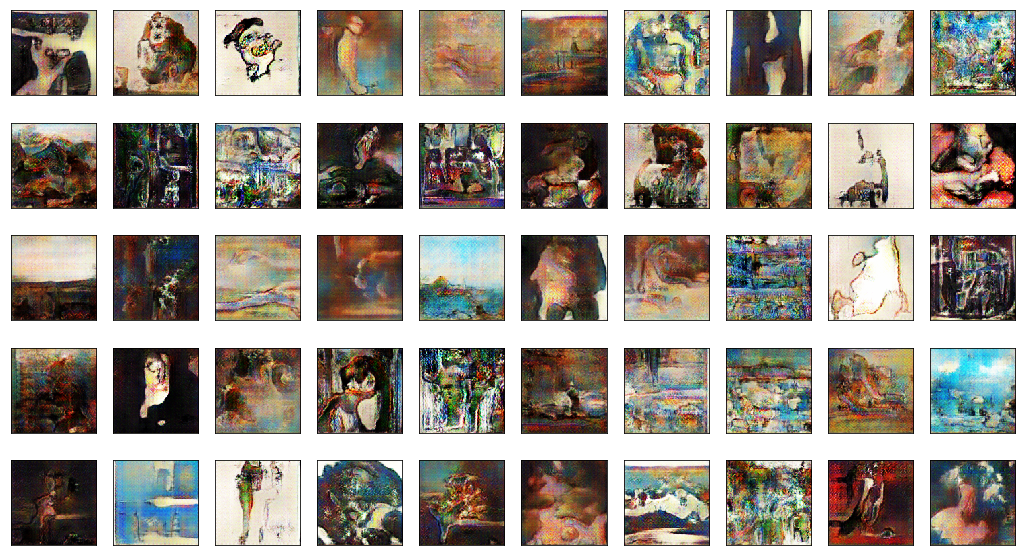

In [65]:
z = torch.FloatTensor(50, 100, 1, 1).normal_()
show_result(G, z)

In [15]:
def show_interpolation(z1, z2, n, mode = 'lerp', G=G):
    z1 = z1.view(1,-1,1,1)
    z2 = z2.view(1,-1,1,1)
    vals = np.linspace(0, 1, n)
    z = torch.Tensor([])
    for v in vals:
        if mode == 'lerp':
            res = itp.lerp(v, z1, z2)
        else:
            z1n = z1.numpy().reshape(-1)
            z2n = z2.numpy().reshape(-1)
            res = itp.slerp(v, z1n, z2n)
            res = torch.Tensor(res).view(1,-1,1,1)
            
        z = torch.cat([z, res],0)
        
    show_result(G, z)

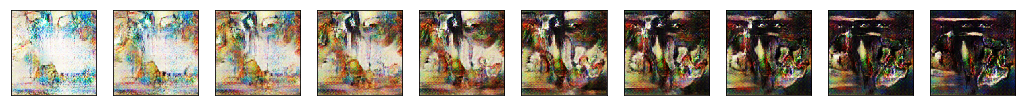

In [16]:
z = torch.FloatTensor(2, 100, 1, 1).normal_()
show_interpolation(z[0], z[1], 10, 'slerp')

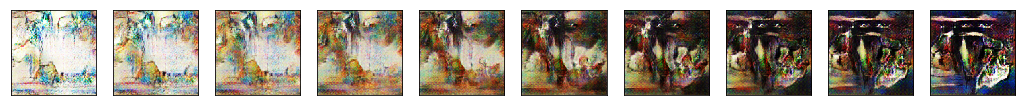

In [17]:
show_interpolation(z[0], z[1], 10, 'lerp')

In [22]:
z1 = z[9].numpy().reshape(-1)
z2 = z[47].numpy().reshape(-1)
d = z1 - z2

IndexError: index 9 is out of range for dimension 0 (of size 2)

In [76]:
idx = np.argsort(abs(d))
idx

array([ 0, 51, 50, 14,  4,  9, 91, 30, 63, 84, 79, 67, 48, 44, 33, 66, 49,
       13, 96, 55, 89, 28, 52, 41, 70, 22, 86,  8, 82, 53, 10,  5, 71, 83,
       72, 98, 46, 17, 39, 74,  7, 34, 54, 78, 25, 36, 62, 93, 29, 88,  2,
       58, 75, 43, 26, 23, 85, 92, 65, 87, 19, 42, 81, 11, 15, 95, 31, 80,
       24, 69, 37, 35, 18, 61,  1, 32, 90, 68, 97, 76, 56, 99, 12, 21, 16,
       60,  6, 47, 27, 73, 40, 38, 64, 94, 77,  3, 45, 59, 20, 57])

In [77]:
d[idx]

array([ 0.00983945,  0.02936998,  0.0304234 , -0.04397905,  0.05568548,
        0.07955147, -0.09299582, -0.12072897,  0.12721932,  0.13038456,
       -0.16133703,  0.19165695, -0.19203284,  0.20081653,  0.20744729,
        0.21029836,  0.21494633, -0.22932851, -0.23338985, -0.23348585,
       -0.25430432, -0.27343288,  0.2736473 ,  0.2885643 ,  0.30489606,
        0.33097678,  0.35641396, -0.40032172, -0.42205262,  0.42860657,
        0.4392063 ,  0.46475402,  0.55297333, -0.56131744,  0.5624536 ,
        0.5663366 , -0.63457847, -0.65205   ,  0.6742427 ,  0.7746733 ,
        0.77533543, -0.8333257 , -0.8743705 ,  0.87964135, -0.88711566,
        0.89097166, -0.8990602 , -0.902315  ,  0.9228241 , -0.9525135 ,
        0.98430413,  0.9991684 ,  1.018213  , -1.0319972 , -1.0532819 ,
       -1.071049  ,  1.0805633 , -1.0935133 ,  1.1118375 ,  1.1250842 ,
       -1.148758  , -1.1507907 , -1.1520808 ,  1.2297072 ,  1.238888  ,
       -1.2774732 , -1.2965473 , -1.2967833 , -1.3199176 ,  1.37

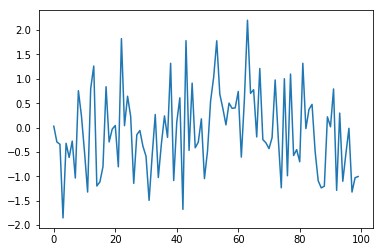

In [24]:
plt.plot(z[0].numpy().reshape(-1))

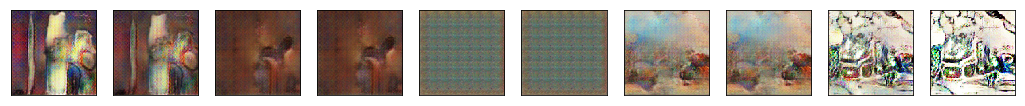

In [19]:
#check for other dimensions (for loop)
#substract to get differences; add to other samples?
p = torch.FloatTensor([-5] + 99*[0]).view(-1,1,1)
q = torch.FloatTensor([5] + 99*[0]).view(-1,1,1)
show_interpolation(p,q,10,'slerp')

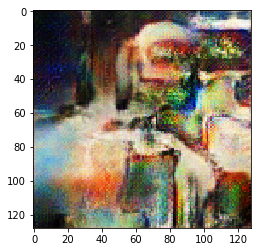

In [20]:
p = torch.FloatTensor([-10] + 99*[0]).view(1,-1,1,1)
show_result(G,p)

In [87]:
show_result(G,d)

RuntimeError: Variable data has to be a tensor, but got numpy.ndarray

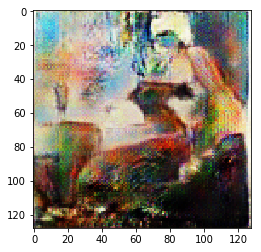

In [90]:
d_tensor = torch.Tensor(d).view(1,-1,1,1)
show_result(G,d_tensor)